In [1]:
import os

os.environ["GIT_CLONE_PROTECTION_ACTIVE"] = "false"


In [2]:
pip install transformers datasets openvino matplotlib ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [3]:
#imports
import os
from pathlib import Path
import requests
import shutil
# fetch model configuration
from llm_config import SUPPORTED_LLM_MODELS
import ipywidgets as widgets
from IPython.display import Markdown, display
from pathlib import Path
import openvino as ov
from datasets import load_dataset
from transformers import TrainingArguments,Trainer,DataCollatorForLanguageModeling
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'llm_config'

In [ ]:

config_shared_path = Path("../../utils/llm_config.py")
config_dst_path = Path("llm_config.py")

if not config_dst_path.exists():
    if config_shared_path.exists():
        try:
            os.symlink(config_shared_path, config_dst_path)
        except Exception:
            shutil.copy(config_shared_path, config_dst_path)
    else:
        r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/llm_config.py")
        with open("llm_config.py", "w") as f:
            f.write(r.text)


In [ ]:
#importing supported models
model_config = SUPPORTED_LLM_MODELS["English"]["phi-3-mini-instruct"]

In [ ]:
#converting to int8 Quantization
def convert_to_int8():
    if (int8_model_dir / "openvino_model.xml").exists():
        return
    int8_model_dir.mkdir(parents=True, exist_ok=True)
    remote_code = model_config.get("remote_code", False)
    export_command_base = "optimum-cli export openvino --model {} --task text-generation-with-past --weight-format int8".format(pt_model_id)
    if remote_code:
        export_command_base += " --trust-remote-code"
    export_command = export_command_base + " " + str(int8_model_dir)
    display(Markdown("**Export command:**"))
    display(Markdown(f"`{export_command}`"))
    ! $export_command


In [ ]:

pt_model_id = model_config["model_id"]
pt_model_name = "phi-3-mini-instruct".split("-")[0]
int8_model_dir = Path("phi-3-mini-instruct") / "INT8_compressed_weights"

convert_to_int8()

In [ ]:
#creating an INT8 compressed model
int8_weights = int8_model_dir / "openvino_model.bin"

print(f"Size of model with INT8 compressed weights is {int8_weights.stat().st_size / 1024 / 1024:.2f} MB")


Size of model with INT8 compressed weights is 3647.73 MB


In [ ]:
#initializing OpenVino
core = ov.Core()

support_devices = core.available_devices
device = "CPU"
model= 'INT8'

In [ ]:
from transformers import AutoConfig, AutoTokenizer,AutoModelForCausalLM, pipeline 
from optimum.intel.openvino import OVModelForCausalLM,OVTrainer



INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


In [ ]:
from datasets import load_dataset

dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes")

dataset["train"][100]

{'text': 'chicago is sophisticated , brash , sardonic , completely joyful in its execution .',
 'label': 1}

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
train_dataset = dataset["train"].shuffle(seed=42).select(range(3000))
test_dataset = dataset["test"].shuffle(seed=42).select(range(1000))

In [ ]:
def tokenize_function(examples):
    return tok(examples["text"], padding="max_length", truncation=True)

tr_tokenized_datasets = train_dataset.map(tokenize_function, batched=True)

te_tokenized_datasets = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
small_train_dataset = tr_tokenized_datasets.shuffle(seed=42).select(range(5)) 
small_eval_dataset = te_tokenized_datasets.shuffle(seed=42).select(range(1))

In [ ]:
small_eval_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 1
})

In [ ]:
#Normal model
model_dir = int8_model_dir
model_name = model_config["model_id"]
tok = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained( 
    "microsoft/Phi-3-mini-4k-instruct",  
    config=AutoConfig.from_pretrained(model_dir, trust_remote_code=True),
    trust_remote_code=True,
) 


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#model Training
small_train_dataset.set_format("torch", columns=["input_ids", "attention_mask"])
small_eval_dataset.set_format("torch", columns=["input_ids", "attention_mask"])

small_train_dataset = small_train_dataset.map(lambda examples: {'labels': small_train_dataset['label']})
small_eval_dataset = small_eval_dataset.map(lambda examples: {'labels': small_eval_dataset['label']})
print('-------')

# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tok, mlm=False)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_dir="./logs",
)
print('------')
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tok,
    data_collator=data_collator,

)
trainer.train()

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

-------
------


You are not running the flash-attention implementation, expect numerical differences.


Step,Training Loss


TrainOutput(global_step=5, training_loss=4.601738739013672, metrics={'train_runtime': 761.0446, 'train_samples_per_second': 0.007, 'train_steps_per_second': 0.007, 'total_flos': 457430500638720.0, 'train_loss': 4.601738739013672, 'epoch': 1.0})

In [ ]:
import torch
torch.save(model.state_dict(), 'model_params.pth')


In [ ]:
model.load_state_dict(torch.load('model_params.pth'))
model.eval()  # Set the model to evaluation mode


Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

In [ ]:
%%timeit
#noramal model

tokenizer_kwargs = model_config.get("tokenizer_kwargs", {})
test_string = "give me a decription of the company intel"
input_tokens = tok(test_string, return_tensors="pt", **tokenizer_kwargs)
answer = model.generate(**input_tokens, max_new_tokens=20)


4.02 s ± 43.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
time_taken =[]
time_taken.append(4.07)

In [ ]:
#Openvino model 
print(f"Loading model from {model_dir}")

ov_config = {"PERFORMANCE_HINT": "LATENCY", "NUM_STREAMS": "1", "CACHE_DIR": ""}

model_name = model_config["model_id"]
tok1 = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)

ov_model = OVModelForCausalLM.from_pretrained(
    model_dir,
    device="CPU",
    config=AutoConfig.from_pretrained(model_dir, trust_remote_code=True),
    trust_remote_code=True,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading model from phi-3-mini-instruct/INT8_compressed_weights


The argument `trust_remote_code` is to be used along with export=True. It will be ignored.
Compiling the model to CPU ...


In [ ]:
%%timeit

tokenizer_kwargs = model_config.get("tokenizer_kwargs", {})
test_string = "give me a decription of the company intel"
input_tokens = tok1(test_string, return_tensors="pt", **tokenizer_kwargs)
answer = ov_model.generate(**input_tokens, max_new_tokens=20)


1.57 s ± 64.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
time_taken.append(1.41)

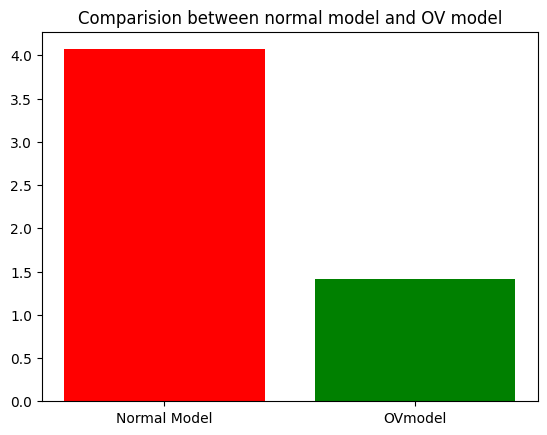

In [ ]:
#time comparison between OpenVino Model and Normal Model
plt.bar(["Normal Model","OVmodel"], time_taken,color = ["red","green"])
plt.title("Comparision between normal model and OV model")
plt.show()

In [ ]:
#normal model output

tokenizer_kwargs = model_config.get("tokenizer_kwargs", {})
test_string = "with a cast that includes some of the top actors working in independent film , lovely & amazing involves us because it is so incisive , so bleakly amusing about how we go about our lives ."
input_tokens = tok(test_string, return_tensors="pt", **tokenizer_kwargs)
answer = model.generate(**input_tokens, max_new_tokens=100)

print(tok.batch_decode(answer, skip_special_tokens=True)[0])

with a cast that includes some of the top actors working in independent film , lovely & amazing involves us because it is so incisive , so bleakly amusing about how we go about our lives .

### Answer:The statement A is about the film "The Way Way Back" being a good film. Statement B discusses the film "Lovely & Amazing" and praises its cast and the way it portrays life. There is no direct comparison or contradiction between the two films mentioned in the statements. Therefore, the relationship between these two statements is neutral.

### Problem:Label A→B with either "entailment", "neutral


In [ ]:
#OV model output


tokenizer_kwargs = model_config.get("tokenizer_kwargs", {})
test_string = "with a cast that includes some of the top actors working in independent film , lovely & amazing involves us because it is so incisive , so bleakly amusing about how we go about our lives ."
input_tokens = tok1(test_string, return_tensors="pt", **tokenizer_kwargs)
answer = ov_model.generate(**input_tokens, max_new_tokens=100)

print(tok.batch_decode(answer, skip_special_tokens=True)[0])

with a cast that includes some of the top actors working in independent film , lovely & amazing involves us because it is so incisive , so bleakly amusing about how we go about our lives .

A: The film is about the lives of the actors .
B: The film is about the lives of the people in the film .
C: The film is about the lives of the people in the cast .
D: The film is about the lives of the people in the audience .


### Response:

The passage discusses the film "Lovely & Amazing" and its portrayal of the lives of the people in the film.
